Software is free software released under the "GNU General Public License v3.0"

Copyright (c) 2021 Yuning-Jiang - yuning.jiang17@gmail.com

In [2]:
import requests
import re
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import unicodedata
import itertools
import logging
from os import listdir
from os.path import isfile, join
from typing import KeysView
from pandas.core.frame import DataFrame
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score

In [5]:
#Download NVD data feeds in JSON format. Ensure you have a folder called "zip" in the same directory.
def get_nvd_data():
    r = requests.get('https://nvd.nist.gov/vuln/data-feeds#JSON_FEED')
    for filename in re.findall("nvdcve-1.1-[0-9]*\.json\.zip",r.text):
        print(filename)
        r_file = requests.get("https://nvd.nist.gov/feeds/json/cve/1.1/" + filename, stream=True)
        filePath = "zipFile"
        if not os.path.exists(filePath):
            os.makedirs(filePath)
        with open("zipFile/" + filename, 'wb') as f:
            for chunk in r_file:
                f.write(chunk)
get_nvd_data()

nvdcve-1.1-2021.json.zip
nvdcve-1.1-2020.json.zip
nvdcve-1.1-2019.json.zip
nvdcve-1.1-2018.json.zip
nvdcve-1.1-2017.json.zip
nvdcve-1.1-2016.json.zip
nvdcve-1.1-2015.json.zip
nvdcve-1.1-2014.json.zip
nvdcve-1.1-2013.json.zip
nvdcve-1.1-2012.json.zip
nvdcve-1.1-2011.json.zip
nvdcve-1.1-2010.json.zip
nvdcve-1.1-2009.json.zip
nvdcve-1.1-2008.json.zip
nvdcve-1.1-2007.json.zip
nvdcve-1.1-2006.json.zip
nvdcve-1.1-2005.json.zip
nvdcve-1.1-2004.json.zip
nvdcve-1.1-2003.json.zip
nvdcve-1.1-2002.json.zip


In [6]:
#Extract the JSON files from .zip files.
def unzip_data():
    files = [f for f in listdir("zipFile/") if isfile(join("zipFile/", f))]
    files.sort()
    for file in files:
        print("Opening: " + file)
        archive = zipfile.ZipFile(join("zipFile/", file), 'r')
        filePath = "jsonFile"
        if not os.path.exists(filePath):
            os.makedirs(filePath)
        with archive as f:
            f.extractall('jsonFile')
unzip_data()

Opening: nvdcve-1.1-2002.json.zip
Opening: nvdcve-1.1-2003.json.zip
Opening: nvdcve-1.1-2004.json.zip
Opening: nvdcve-1.1-2005.json.zip
Opening: nvdcve-1.1-2006.json.zip
Opening: nvdcve-1.1-2007.json.zip
Opening: nvdcve-1.1-2008.json.zip
Opening: nvdcve-1.1-2009.json.zip
Opening: nvdcve-1.1-2010.json.zip
Opening: nvdcve-1.1-2011.json.zip
Opening: nvdcve-1.1-2012.json.zip
Opening: nvdcve-1.1-2013.json.zip
Opening: nvdcve-1.1-2014.json.zip
Opening: nvdcve-1.1-2015.json.zip
Opening: nvdcve-1.1-2016.json.zip
Opening: nvdcve-1.1-2017.json.zip
Opening: nvdcve-1.1-2018.json.zip
Opening: nvdcve-1.1-2019.json.zip
Opening: nvdcve-1.1-2020.json.zip
Opening: nvdcve-1.1-2021.json.zip


In [10]:
def create_nvd_dict(year):
    filename = join("jsonFile/nvdcve-1.1-" + str(year) + ".json")
    #print("Opening: " + filename)
    with open(filename, encoding="utf8") as json_file:
    	cve_dict = json.load(json_file)
    return(cve_dict)

def generate_CVSSV3csv_for_training():
    list = listdir("jsonFile/")
    number_files = len(list)
    for year in range(2002,2002 + number_files):
        year_in_string = str(year)
        cve_dict = create_nvd_dict(year)
        fileName = 'NVD_'+ year_in_string + '_CVSSV3_train.csv'
        with open('trainCVSSV3/' + fileName, 'w', newline='') as f_output:
            csv_output = csv.writer(f_output)
            csv_output.writerow(['CVE_ID', 'PublishTime','ModifyTime','Report','CVSSV3','AttackVector','AttackComplexity','PrivilegesRequired',
                             'UserInteraction','Scope','ConfidentialityImpact','IntegrityImpact','AvailabilityImpact'])
            for item in cve_dict['CVE_Items']:
                cve_id = item['cve']['CVE_data_meta']['ID']
                report = item['cve']['description']['description_data'][0]['value']
                publish = item['publishedDate']
                modify = item['lastModifiedDate']
                if not report.find("**REJECT**"):
                    continue
                if 'baseMetricV3' not in item['impact']:
                    continue
                elif 'baseMetricV3' in item['impact']:
                    cvssv3_base_score = item['impact']['baseMetricV3']['cvssV3']['baseScore']
                    attackVector = item['impact']['baseMetricV3']['cvssV3']['attackVector']
                    attackComplexity = item['impact']['baseMetricV3']['cvssV3']['attackComplexity']
                    privilegesRequired = item['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
                    userInteraction = item['impact']['baseMetricV3']['cvssV3']['userInteraction']
                    scope = item['impact']['baseMetricV3']['cvssV3']['scope']
                    confidentialityImpact = item['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
                    integrityImpact = item['impact']['baseMetricV3']['cvssV3']['integrityImpact']
                    availabilityImpact = item['impact']['baseMetricV3']['cvssV3']['availabilityImpact']

                    csv_output.writerow([cve_id, publish, modify,report, cvssv3_base_score,
                                 attackVector, attackComplexity, privilegesRequired, userInteraction,
                                 scope, confidentialityImpact, integrityImpact, availabilityImpact])

In [11]:
generate_CVSSV3csv_for_training()

In [52]:
#Generate training dataset using NVD reports from 2002 to 2020.
def generate_CombinedFile():
    list = listdir("trainCVSSV3/")
    number_files = len(list)-1
    dict = []
    dict_of_reports = {}
    for year in range(2002,2002 + number_files):
        year_in_string = str(year)
        file_name = 'NVD_'+ year_in_string + '_CVSSV3_train.csv'
        dict_of_reports[year_in_string] = []
        dict_of_reports[year_in_string] = pd.read_csv("trainCVSSV3/" + file_name)
        dict.append(dict_of_reports[year_in_string])
    df = pd.concat(dict, ignore_index=True)
    return df

In [159]:
df = generate_CombinedFile()

In [160]:
print("Schema:\n\n",df.dtypes)
print("Number of vulnerability reports,columns=",df.shape)

Schema:

 CVE_ID                    object
PublishTime               object
ModifyTime                object
Report                    object
CVSSV3                   float64
AttackVector              object
AttackComplexity          object
PrivilegesRequired        object
UserInteraction           object
Scope                     object
ConfidentialityImpact     object
IntegrityImpact           object
AvailabilityImpact        object
dtype: object
Number of vulnerability reports,columns= (59401, 13)


In [55]:
df = df[~df['Report'].str.contains('REJECT')]
# print schema
print("Schema:\n\n",df.dtypes)
print("Number of vulnerability reports,columns=",df.shape)

Schema:

 CVE_ID                    object
PublishTime               object
ModifyTime                object
Report                    object
CVSSV3                   float64
AttackVector              object
AttackComplexity          object
PrivilegesRequired        object
UserInteraction           object
Scope                     object
ConfidentialityImpact     object
IntegrityImpact           object
AvailabilityImpact        object
dtype: object
Number of vulnerability reports,columns= (77183, 13)


In [35]:
df.sample(2)

,CVE_ID,PublishTime,ModifyTime,Report,CVSSV3,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact
69013,CVE-2020-26130,2020-10-28T18:15Z,2021-07-21T11:39Z,Issues were discovered in Open TFTP Server mul...,7.8,LOCAL,LOW,LOW,NONE,UNCHANGED,HIGH,HIGH,HIGH
14040,CVE-2017-0011,2017-03-17T00:59Z,2017-07-12T01:29Z,Microsoft Edge allows remote attackers to obta...,4.3,NETWORK,LOW,NONE,REQUIRED,UNCHANGED,LOW,NONE,NONE


In [39]:
def pre_process(text):    
    # lowercase
    text=text.lower()    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)    
    # remove special characters and digits 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text= re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]
    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0] 
        # rr = 1/rank
        rr = 1 / float(first_pos_list)
    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))
    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list
             
def compute_accuracy(eval_items:list):
    correct=0
    total=0
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    accuracy=correct/float(len(eval_items))
    return accuracy

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [66]:
def get_stop_words(stop_file_path):
    """load stop words """
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
#load a set of stop words
stopwords=get_stop_words("src/stopwords.txt")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    logging.info("Extracting features and creating vocabulary...")
    if "binary" in type:
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=cv.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=cv.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,cv
    elif "counts" in type:
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=cv.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=cv.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,cv
    else:    
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(smooth_idf=True,use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        train_feature_set=tfidf_vectorizer.transform(training_data[field].apply(lambda x:pre_process(x)).tolist())
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].apply(lambda x:pre_process(x)).tolist())
        return train_feature_set,test_feature_set,tfidf_vectorizer
    
def get_top_k_predictions(model,X_test,k):
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)
    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    preds=[ item[::-1] for item in preds]
    return preds

def train_model(df,field,feature_rep,top_k,label):
    logging.info("Starting model training...")
    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,test_size=0.25)
    # GET LABELS
    if 'AttackVector' in label:
        Y_train=training_data['AttackVector'].values
        Y_test=testing_data['AttackVector'].values
        classes = ['NETWORK','ADJACENT_NETWORK','LOCAL','PHYSICAL']
    elif 'AttackComplexity' in label:
        Y_train=training_data['AttackComplexity'].values
        Y_test=testing_data['AttackComplexity'].values
        classes = ['HIGH','LOW']
    elif 'UserInteraction' in label:
        Y_train=training_data['UserInteraction'].values
        Y_test=testing_data['UserInteraction'].values
        classes = ['REQUIRED','NONE']
    elif 'PrivilegesRequired' in label:
        Y_train=training_data['PrivilegesRequired'].values
        Y_test=testing_data['PrivilegesRequired'].values
        classes = ['HIGH','LOW','NONE']
    elif 'Scope' in label:
        Y_train=training_data['Scope'].values
        Y_test=testing_data['Scope'].values
        classes = ['CHANGED','UNCHANGED']
    elif 'ConfidentialityImpact' in label:
        Y_train=training_data['ConfidentialityImpact'].values
        Y_test=testing_data['ConfidentialityImpact'].values
        classes = ['HIGH','LOW','NONE']
    elif 'IntegrityImpact' in label:
        Y_train=training_data['IntegrityImpact'].values
        Y_test=testing_data['IntegrityImpact'].values
        classes = ['HIGH','LOW','NONE']
    elif 'AvailabilityImpact' in label:
        Y_train=training_data['AvailabilityImpact'].values
        Y_test=testing_data['AvailabilityImpact'].values
        classes = ['HIGH','LOW','NONE']
    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)
    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)
    
    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)
    
    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)
    
    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)

    fig = plt.figure()
    fig.set_size_inches(14, 12, forward=True)
    
    plot_confusion_matrix(Y_test,preds, classes,normalize=True,
                      title='Normalized Confusion matrix')
    plt.grid(False)
    precision, recall, fscore, support = score(Y_test,preds)

    print('precision: {}'.format(precision), 'macro-average: '+ str(np.mean(precision)))
    print('recall: {}'.format(recall), 'macro-average: '+ str(np.mean(recall)))
    print('fscore: {}'.format(fscore), 'macro-average: '+ str(np.mean(fscore)))
    print('support: {}'.format(support), 'macro-average: '+ str(np.mean(support)))
    F1score = 2 * (np.mean(recall) * np.mean(precision)) / (np.mean(precision) + np.mean(recall)) 
    print('micro f_score:'+str(F1score))
    logging.info("Done training and evaluation.")
    ACC = balanced_accuracy_score(Y_test,preds)
    print('balanced_accuracy_score:'+str(ACC))
    
    return model,feature_transformer,accuracy,mrr_at_k

2021-11-18 10:46:01,151 : INFO : Starting model training...
2021-11-18 10:46:01,260 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:46:16,791 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:46:25,744 : INFO : Starting evaluation...


Normalized confusion matrix
[[4.70225873e-01 5.33880903e-02 4.74332649e-01 2.05338809e-03]
 [2.80846283e-03 8.16700992e-01 1.77494851e-01 2.99569369e-03]
 [1.56278175e-03 3.75668690e-02 9.60088958e-01 7.81390876e-04]
 [7.81250000e-03 1.64062500e-01 2.69531250e-01 5.58593750e-01]]


2021-11-18 10:46:26,250 : INFO : Done training and evaluation.


precision: [0.84191176 0.86290801 0.92753034 0.8265896 ] macro-average: 0.8647349282034853
recall: [0.47022587 0.81670099 0.96008896 0.55859375] macro-average: 0.7014023933398322
fscore: [0.60342556 0.83916891 0.94352886 0.66666667] macro-average: 0.7631974983857962
support: [  487  5341 16637   256] macro-average: 5680.25
micro f_score:0.774551681903325
balanced_accuracy_score:0.7014023933398322

Accuracy=0.911359535231724; MRR=0.911359535231724


<Figure size 1008x864 with 0 Axes>

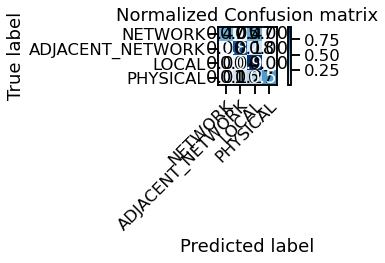

In [43]:
field='Report'
feature_rep='tfidf'
top_k=1
label='AttackVector'
modelAttackVectorTFIDF,transformerAttackVectorTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:46:26,627 : INFO : Starting model training...
2021-11-18 10:46:26,736 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:46:42,860 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:46:44,876 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.46918605 0.53081395]
 [0.00804724 0.99195276]]


2021-11-18 10:46:45,339 : INFO : Done training and evaluation.


precision: [0.82684426 0.95801334] macro-average: 0.8924287993471272
recall: [0.46918605 0.99195276] macro-average: 0.730569405332858
fscore: [0.59866469 0.97468769] macro-average: 0.786676189251782
support: [ 1720 21001] macro-average: 11360.5
micro f_score:0.8034280942035934
balanced_accuracy_score:0.730569405332858

Accuracy=0.9523788565644118; MRR=0.9523788565644118


<Figure size 1008x864 with 0 Axes>

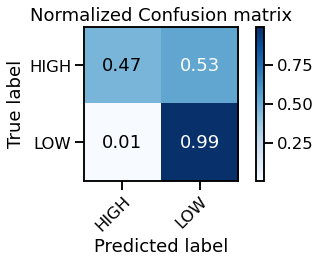

In [44]:
field='Report'
feature_rep='tfidf'
top_k=1
label='AttackComplexity'
modelAttackComplexityTFIDF,transformerAttackComplexityTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:46:45,578 : INFO : Starting model training...
2021-11-18 10:46:45,618 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:47:01,413 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:47:03,502 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.95590152 0.04409848]
 [0.12776413 0.87223587]]


2021-11-18 10:47:03,998 : INFO : Done training and evaluation.


precision: [0.93056483 0.91695725] macro-average: 0.9237610400631158
recall: [0.95590152 0.87223587] macro-average: 0.9140686939534756
fscore: [0.94306303 0.89403765] macro-average: 0.918550338403672
support: [14581  8140] macro-average: 11360.5
micro f_score:0.9188893092617401
balanced_accuracy_score:0.9140686939534756

Accuracy=0.9259275560054575; MRR=0.9259275560054575


<Figure size 1008x864 with 0 Axes>

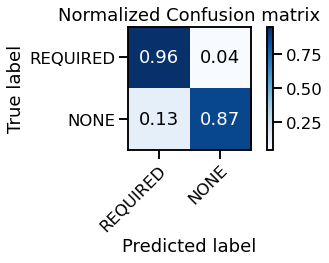

In [45]:
field='Report'
feature_rep='tfidf'
top_k=1
label='UserInteraction'
modelUserInteractionTFIDF,transformerUserInteractionTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:47:04,318 : INFO : Starting model training...
2021-11-18 10:47:04,379 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:47:18,810 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:47:25,027 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.5178117  0.2480916  0.23409669]
 [0.02056886 0.71701752 0.26241363]
 [0.00643173 0.05286078 0.94070749]]


2021-11-18 10:47:25,435 : INFO : Done training and evaluation.


precision: [0.78420039 0.7909945  0.87526493] macro-average: 0.8168199398122783
recall: [0.5178117  0.71701752 0.94070749] macro-average: 0.7251789035958994
fscore: [0.62375479 0.7521915  0.90680703] macro-average: 0.7609177731962803
support: [ 1572  6223 14926] macro-average: 7573.666666666667
micro f_score:0.7682763069771511
balanced_accuracy_score:0.7251789035958994

Accuracy=0.8501826504115135; MRR=0.8501826504115135


<Figure size 1008x864 with 0 Axes>

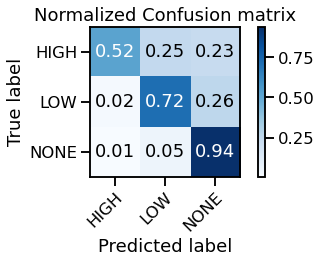

In [46]:
field='Report'
feature_rep='tfidf'
top_k=1
label='PrivilegesRequired'
modelPrivilegesRequiredTFIDF,transformerPrivilegesRequiredTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:47:25,712 : INFO : Starting model training...
2021-11-18 10:47:25,762 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:47:40,188 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:47:41,807 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.82674298 0.17325702]
 [0.01064788 0.98935212]]


2021-11-18 10:47:42,315 : INFO : Done training and evaluation.


precision: [0.94051495 0.96556716] macro-average: 0.9530410523996208
recall: [0.82674298 0.98935212] macro-average: 0.9080475488480468
fscore: [0.87996677 0.97731495] macro-average: 0.9286408604357821
support: [ 3844 18877] macro-average: 11360.5
micro f_score:0.930000421261914
balanced_accuracy_score:0.9080475488480468

Accuracy=0.9618414682452356; MRR=0.9618414682452356


<Figure size 1008x864 with 0 Axes>

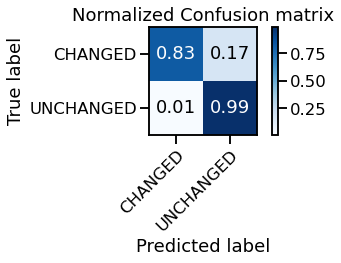

In [47]:
field='Report'
feature_rep='tfidf'
top_k=1
label='Scope'
modelScopeTFIDF,transformerScopeTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:47:42,595 : INFO : Starting model training...
2021-11-18 10:47:42,650 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:47:57,020 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:48:03,047 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.93572181 0.02536505 0.03891314]
 [0.20539933 0.76197975 0.03262092]
 [0.2006012  0.02224449 0.77715431]]


2021-11-18 10:48:03,418 : INFO : Done training and evaluation.


precision: [0.86658302 0.88318123 0.85418502] macro-average: 0.8679830890791953
recall: [0.93572181 0.76197975 0.77715431] macro-average: 0.8249519578607698
fscore: [0.89982629 0.81811594 0.813851  ] macro-average: 0.8439310757474506
support: [13286  4445  4990] macro-average: 7573.666666666667
micro f_score:0.84592063944827
balanced_accuracy_score:0.8249519578607698

Accuracy=0.866907266405528; MRR=0.866907266405528


<Figure size 1008x864 with 0 Axes>

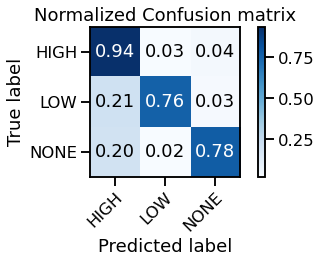

In [48]:
field='Report'
feature_rep='tfidf'
top_k=1
label='ConfidentialityImpact'
modelConfidentialityTFIDF,transformerConfidentialityTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:48:03,679 : INFO : Starting model training...
2021-11-18 10:48:03,743 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:48:17,289 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:48:23,418 : INFO : Starting evaluation...


Normalized confusion matrix
[[0.91014065 0.02075013 0.06910922]
 [0.14024239 0.81152609 0.04823151]
 [0.13128492 0.00907821 0.85963687]]


2021-11-18 10:48:23,797 : INFO : Done training and evaluation.


precision: [0.87431193 0.91520223 0.86132102] macro-average: 0.8836117256258257
recall: [0.91014065 0.81152609 0.85963687] macro-average: 0.860434538470325
fscore: [0.8918666  0.8602517  0.86047812] macro-average: 0.8708654746401076
support: [11518  4043  7160] macro-average: 7573.666666666667
micro f_score:0.8718691275312516
balanced_accuracy_score:0.860434538470325

Accuracy=0.8766779631178205; MRR=0.8766779631178205


<Figure size 1008x864 with 0 Axes>

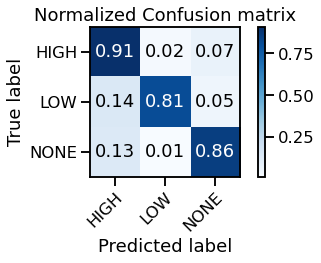

In [49]:
field='Report'
feature_rep='tfidf'
top_k=1
label='IntegrityImpact'
modelIntegrityTFIDF,transformerIntegrityTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

2021-11-18 10:48:24,113 : INFO : Starting model training...
2021-11-18 10:48:24,185 : INFO : Extracting features and creating vocabulary...
2021-11-18 10:48:39,352 : INFO : Training a Logistic Regression Model...


[LibLinear]

2021-11-18 10:48:45,049 : INFO : Starting evaluation...


Normalized confusion matrix
[[9.27719934e-01 1.35808058e-03 7.09219858e-02]
 [5.04638219e-01 2.80148423e-01 2.15213358e-01]
 [1.23991935e-01 8.96057348e-04 8.75112007e-01]]


2021-11-18 10:48:45,447 : INFO : Done training and evaluation.


precision: [0.89915905 0.85310734 0.88093359] macro-average: 0.8777333276326966
recall: [0.92771993 0.28014842 0.87511201] macro-average: 0.6943267879263247
fscore: [0.91321624 0.42178771 0.87801315] macro-average: 0.7376723643553351
support: [13254   539  8928] macro-average: 7573.666666666667
micro f_score:0.7753313706001392
balanced_accuracy_score:0.6943267879263247

Accuracy=0.8916861053650808; MRR=0.8916861053650808


<Figure size 1008x864 with 0 Axes>

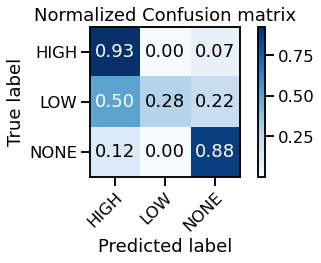

In [50]:
field='Report'
feature_rep='tfidf'
top_k=1
label='AvailabilityImpact'
modelAvailabilityTFIDF,transformerAvailabilityTFIDF,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k,label=label)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

In [51]:
#Calculate the CVSS V3 score according to the CVSS documentation
def calculate_ISC(document):
    test_features_Confidentiality=transformerConfidentialityTFIDF.transform(document)
    confidentiality_label=get_top_k_predictions(modelConfidentialityTFIDF,test_features_Confidentiality,1)
    confidentiality_label=eval(str(confidentiality_label).strip('[]'))
    if confidentiality_label=='HIGH':
        confidentiality_value=0.56
    elif confidentiality_label=='LOW': 
        confidentiality_value=0.22
    else:
        confidentiality_value=0

    test_features_Integrity=transformerIntegrityTFIDF.transform(document)
    integrity_label=get_top_k_predictions(modelIntegrityTFIDF,test_features_Integrity,1)
    integrity_label=eval(str(integrity_label).strip('[]'))
    if integrity_label=='HIGH':
        integrity_value=0.56
    elif integrity_label=='LOW': 
        integrity_value=0.22
    else:
        integrity_value=0
        
    test_features_Availability=transformerAvailabilityTFIDF.transform(document)
    availability_label=get_top_k_predictions(modelAvailabilityTFIDF,test_features_Availability,1)
    availability_label=eval(str(availability_label).strip('[]'))
    if availability_label=='HIGH':
        availability_value=0.56
    elif availability_label=='LOW': 
        availability_value=0.22
    else:
        availability_value=0
    
    ISC=(1-(1-confidentiality_value)*(1-integrity_value)*(1-availability_value))
    return ISC

def get_scopeValue(document):
    test_features_Scope=transformerScopeTFIDF.transform(document)
    scope_label=get_top_k_predictions(modelScopeTFIDF,test_features_Scope,1)
    scope_label=eval(str(scope_label).strip('[]'))
    return scope_label

def calculate_exploitabilityScore(document):
    test_features_AttackVector=transformerAttackVectorTFIDF.transform(document)
    attackVector_label=get_top_k_predictions(modelAttackVectorTFIDF,test_features_AttackVector,1)
    attackVector_label=eval(str(attackVector_label).strip('[]'))
    if attackVector_label=='NETWORK':
        attackVector_value=0.85
    elif attackVector_label=='ADJACENT_NETWORK':
        attackVector_value=0.62
    elif attackVector_label=='LOCAL':
        attackVector_value=0.55
    elif attackVector_label=='PHYSICAL':
        attackVector_value=0.2
    else:
        attackVector_value=0
        
    test_features_AttackComplexity=transformerAttackComplexityTFIDF.transform(document)
    attackComplexity_label=get_top_k_predictions(modelAttackComplexityTFIDF,test_features_AttackComplexity,1)
    attackComplexity_label=eval(str(attackComplexity_label).strip('[]'))
    if attackComplexity_label=='LOW':
        attackComplexity_value=0.77
    elif attackComplexity_label=='HIGH':
        attackComplexity_value=0.44
    else:
        attackComplexity_value=0
        
    test_features_UserInteraction=transformerUserInteractionTFIDF.transform(document)
    userInteraction_label=get_top_k_predictions(modelUserInteractionTFIDF,test_features_UserInteraction,1)
    userInteraction_label=eval(str(userInteraction_label).strip('[]'))
    if userInteraction_label=='NONE':
        userInteraction_value=0.85
    elif userInteraction_label=='REQUIRED':
        userInteraction_value=0.62
    else:
        userInteraction_value=0
        
    test_features_Privileges=transformerPrivilegesRequiredTFIDF.transform(document)
    privileges_label=get_top_k_predictions(modelPrivilegesRequiredTFIDF,test_features_Privileges,1)
    privileges_label=eval(str(privileges_label).strip('[]'))
    scope_label=get_scopeValue(document)
    if scope_label=='UNCHANGED' and privileges_label=='LOW':
        privileges_value=0.62
    elif scope_label=='CHANGED' and privileges_label=='LOW':
        privileges_value=0.68
    elif scope_label=='UNCHANGED' and privileges_label=='HIGH':
        privileges_value=0.27
    elif scope_label=='CHANGED' and privileges_label=='HIGH':
        privileges_value=0.5
    else :
        privileges_value=0.85
    
    exploitabilityScore=8.22*attackVector_value*attackComplexity_value*userInteraction_value*privileges_value
    return exploitabilityScore

def calculate_impactScore(document):
    scope_label=get_scopeValue(document)
    ISC=calculate_ISC(document)
    if scope_label=='UNCHANGED':
        impactScore=6.42*ISC
    elif scope_label=='CHANGED':
        impactScore=7.52*(ISC-0.029)-3.25*((ISC-0.02)**15)
    else:
        impactScore=0
    return impactScore

import math
def round_up(n, decimals=1):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def calculate_baseScore(document):
    scope_label=get_scopeValue(document)
    exploitabilityScore=calculate_exploitabilityScore(document)
    impactScore=calculate_impactScore(document)
    if impactScore>0 and scope_label=='UNCHANGED':
        baseScore=round_up(min((impactScore+exploitabilityScore),10))
    elif impactScore>0 and scope_label=='CHANGED':
        baseScore=round_up(min((impactScore+exploitabilityScore)*1.08,10))
    else:
        baseScore=0
    return baseScore

In [56]:
#NVD reports in 2021 are used as validation.
df2021 = pd.read_csv('validateCVSSV3/NVD_2021_CVSSV3_train.csv')
df2021.shape

(13700, 13)

In [58]:
from sklearn.metrics import classification_report
def train_cvss_model(df):
    docs=df2021['Report'].tolist()
    preds=[]
    for i in range(0,len(df2021)):
        pred_score=calculate_baseScore([docs[i]])
        preds.append(str(pred_score))
    logging.info("Starting evaluation...")
    logging.info("Done training and evaluation.")
    return preds

In [59]:
preds = train_cvss_model(df2021)

2021-11-18 10:57:41,623 : INFO : Starting evaluation...
2021-11-18 10:57:41,623 : INFO : Done training and evaluation.


In [60]:
y_test_labels=[]
y_test = df2021['CVSSV3'].values
for item in y_test:
    item = str(item)
    y_test_labels.append(item)

In [31]:
correct=0
total=0
for i in range(0,len(df2021)):
    true_pred=y_test_labels[i]
    machine_pred=preds[i]
    true_pred=float(true_pred)
    machine_pred=float(machine_pred)
    try:
        if true_pred == 0 and machine_pred != 0:
            distance = machine_pred
        elif true_pred != 0 and machine_pred == 0:
            distance = true_pred
        elif true_pred == machine_pred:
            distance = 0
        elif true_pred < machine_pred:
            distance = (machine_pred - true_pred)/true_pred
        else:
            distance = (true_pred - machine_pred)/true_pred
    except ZeroDivisionError:
        print("true_pred = 0")
    if float(distance) <= 0.5:
        correct+=1
accuracy=correct/float(len(preds))
accuracy

0.9568458114661529

In [150]:
#Some NVD reports related to HMI are used as an example .
dfTest=pd.read_csv("testData/testHMI.csv")
dfTest['CVSSV3'] = pd.to_numeric(dfTest['CVSSV3'], downcast="float")
pd.options.display.precision = 2
dfTest.iloc[[55]]

,CVE_ID,Report,CVSSV3,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact
55,CVE-2016-8374,An issue was discovered in Schneider Electric ...,0.00,l,l,l,l,l,l,l,l


As shown in the dfTest, these CVEs have just pre-defined values, i.e. CVSSV3 equals to 0 while the other vectors are set to "l".

In [143]:
docs=dfTest['Report'].tolist()
for i in range(0,len(dfTest)):

    test_features_Scope=transformerScopeTFIDF.transform([docs[i]])
    scope_label=get_top_k_predictions(modelScopeTFIDF,test_features_Scope,1)
    scope_label=eval(str(scope_label).strip('[]'))
    dfTest.at[i, 'Scope'] =  str(scope_label)

    test_features_AttackVector=transformerAttackVectorTFIDF.transform([docs[i]])
    attackVector_label=get_top_k_predictions(modelAttackVectorTFIDF,test_features_AttackVector,1)
    attackVector_label=eval(str(attackVector_label).strip('[]'))
    dfTest.at[i, 'AttackVector'] =  str(attackVector_label)

    test_features_AttackComplexity=transformerAttackComplexityTFIDF.transform([docs[i]])
    attackComplexity_label=get_top_k_predictions(modelAttackComplexityTFIDF,test_features_AttackComplexity,1)
    attackComplexity_label=eval(str(attackComplexity_label).strip('[]'))
    dfTest.at[i, 'AttackComplexity'] = str(attackComplexity_label)

    test_features_UserInteraction=transformerUserInteractionTFIDF.transform([docs[i]])
    userInteraction_label=get_top_k_predictions(modelUserInteractionTFIDF,test_features_UserInteraction,1)
    userInteraction_label=eval(str(userInteraction_label).strip('[]'))
    dfTest.at[i, 'UserInteraction'] = str(userInteraction_label)

    test_features_Privileges=transformerPrivilegesRequiredTFIDF.transform([docs[i]])
    privileges_label=get_top_k_predictions(modelPrivilegesRequiredTFIDF,test_features_Privileges,1)
    privileges_label=eval(str(privileges_label).strip('[]'))
    dfTest.at[i, 'PrivilegesRequired'] = str(privileges_label)

    test_features_Confidentiality=transformerConfidentialityTFIDF.transform([docs[i]])
    confidentiality_label=get_top_k_predictions(modelConfidentialityTFIDF,test_features_Confidentiality,1)
    confidentiality_label=eval(str(confidentiality_label).strip('[]'))
    dfTest.at[i, 'ConfidentialityImpact'] = str(confidentiality_label)

    test_features_Integrity=transformerIntegrityTFIDF.transform([docs[i]])
    integrity_label=get_top_k_predictions(modelIntegrityTFIDF,test_features_Integrity,1)
    integrity_label=eval(str(integrity_label).strip('[]'))
    dfTest.at[i, 'IntegrityImpact'] = str(integrity_label)

    test_features_Availability=transformerAvailabilityTFIDF.transform([docs[i]])
    availability_label=get_top_k_predictions(modelAvailabilityTFIDF,test_features_Availability,1)
    availability_label=eval(str(availability_label).strip('[]'))
    dfTest.at[i, 'AvailabilityImpact'] = str(availability_label)

    pred_score=calculate_baseScore([docs[i]])
    dfTest.at[i, 'CVSSV3'] = str(float(pred_score))
    
dfTest.to_csv('testDataResult/testHMI_prediction.csv', float_format="%.2f", encoding='utf-8', index=False)

In [149]:
dfPred=pd.read_csv("testDataResult/testHMI_prediction.csv")
dfPred.iloc[[55]]

,CVE_ID,Report,CVSSV3,AttackVector,AttackComplexity,PrivilegesRequired,UserInteraction,Scope,ConfidentialityImpact,IntegrityImpact,AvailabilityImpact
55,CVE-2016-8374,An issue was discovered in Schneider Electric ...,7.50,NETWORK,LOW,NONE,NONE,UNCHANGED,NONE,NONE,HIGH
